In [2]:
import numpy as np
import pandas as pd
from scipy.stats import vonmises

In [3]:
import matplotlib.pyplot as plt

In [4]:
ptm_torsion = {
    "SEP": [
        ["N", "CA", "CB", "OG"],
        ["CA", "CB", "OG", "P"],
        ["CB", "OG", "P", "O1P"]
        ],
    "TPO": [
        ["N", "CA", "CB", "OG1"],
        ["CA", "CB", "OG1", "P"],
        ["CB", "OG1", "P", "O1P"]
        ],
    "PTR": [
        ["N", "CA", "CB", "CG"],
        ["CA", "CB", "CG", "CD1"],
        ["CE1", "CZ", "OH", "P"],
        ["CZ", "OH", "P", "O1P"]
        ],
    "M3L": [
        ["N", "CA", "CB", "CG"],
        ["CA", "CB", "CG", "CD"],
        ["CB", "CG", "CD", "CE"],
        ["CG", "CD", "CE", "NZ"],
        ["CD", "CE", "NZ", "CM1"]
        ],
    "ALY": [
        ["N", "CA", "CB", "CG"],
        ["CA", "CB", "CG", "CD"],
        ["CB", "CG", "CD", "CE"],
        ["CG", "CD", "CE", "NZ"],
        ["CD", "CE", "NZ", "CH"]],
    }

free_rotamer = {
    "SEP": "chi3",
    "TPO": "chi3",
    "PTR": "chi4",
    "M3L": "chi5",
}

nchis = {k: len(v) for k, v in ptm_torsion.items()}
# rotamer bin definitions for special cases; sp3 by default
rot_bin_lib = {
    ("PTR", 1): 4,
    ("ALY", 4): 6,
}

In [5]:
# read ptm dataframes
ptm_data = []
for ptm in ptm_torsion:
    ptm_data.append(pd.read_csv(f"data/{ptm}_df.csv"))
ptm_data = pd.concat(ptm_data)

backbone independent library

In [6]:
header = "#AA     Prob   "
line_formatter = "{: <3}  {:8.4f}" #"{:8.1f}""{:8.2f}"

def format_bb_indp_table(lines, residue):
    n_ang = (len(lines[0]) - 1) // 2
    formatter = line_formatter + "{:8.1f}" * n_ang + "{:8.2f}" * n_ang
    table = header + " ".join([f"chi{i+1}Val" for i in range(n_ang)]) + " " + " ".join([f"chi{i+1}Sig" for i in range(n_ang)]) + "\n"
    #table = ""
    for l in lines:
        table += formatter.format(residue, *l) + "\n"
    return table

def rotameric_class(ang, n_splits=3):
    if n_splits == 3:
        if 0 < ang <= 120:
            return 0
        elif -120 < ang <= 0:
            return 2
        return 1
    elif n_splits == 4:
        if 45 < ang <= 135:
            return 0 
        elif -123 < ang <= -45:
            return 2
        elif ang > 135 or ang <= -135:
            return 1
        return 3
    elif n_splits == 6:
        if -30 < ang <= 30:
            return 0 
        elif 30 < ang <= 90:
            return 1
        elif 90 < ang <= 150:
            return 2
        elif ang > 150 or ang <= -150:
            return 3
        elif -150 < ang <= -90:
            return 4
        return 5

def weighted_circmean(angles, weights):
    """
    Compute the weighted circular mean of angular data.

    Parameters:
    angles (array-like): The angular data (in radians).
    weights (array-like): The weights for each angle.

    Returns:
    float: The weighted circular mean of the angular data.
    """
    # Convert angles to complex numbers
    complex_numbers = np.exp(1j * np.array(angles))

    # Compute weighted sum of complex representations
    weighted_sum = np.sum(weights * complex_numbers)

    # Compute the angle of the weighted sum
    mean_angle = np.angle(weighted_sum)

    return mean_angle

def weighted_circstd(angles, weights, mean_angle):
    """
    Compute the weighted circular standard deviation of angular data.

    Parameters:
    angles (array-like): The angular data (in radians).
    weights (array-like): The weights for each angle.
    mean_angle (float): The weighted circular mean of the angular data.

    Returns:
    float: The weighted circular standard deviation of the angular data.
    """
    # Calculate angular differences from the mean, accounting for circularity
    angle_diffs = np.angle(np.exp(1j * (np.array(angles) - mean_angle)))

    # Calculate weighted variance
    weighted_variance = np.sum(weights * angle_diffs**2) / np.sum(weights)

    # Circular standard deviation is the square root of the variance
    circ_std = np.sqrt(weighted_variance)

    return circ_std


For backbone independent rotameric torsion regression

In [7]:
def calc_rotameric_bb_indp(ptm, data, last_free_rot=False):
    results = []
    nchi = nchis[ptm]
    if last_free_rot:
        f_class = data[f"chi{nchi}"].apply(rotameric_class)
        f_stats = np.zeros((3, 3))
        for l in range(3):
            ang_rad = data[f_class==l][f"chi{nchi}"].apply(np.radians)
            kappa, loc, _ = vonmises.fit(ang_rad, fscale=1)
            weights = vonmises(loc=loc, kappa=kappa).pdf(ang_rad)
            wm = weighted_circmean(ang_rad, weights)
            f_stats[l, 0] = len(ang_rad)/len(data)
            f_stats[l, 1] = np.degrees(wm)
            f_stats[l, 2] = np.degrees(weighted_circstd(ang_rad, weights, wm))
        nchi -= 1

    #bins = product(range(3), repeat=nchi)
    chi_classes = []
    for n in range(nchi):
        chi_classes.append(data[f"chi{n+1}"].apply(lambda x: rotameric_class(x, 6 if ptm=="ALY" and n==4 else 3)).values)
    chi_classes = np.array(chi_classes)

    for c in np.unique(chi_classes.T, axis=0):
        mask = np.ones(len(data), dtype=bool)
        for i, l in enumerate(c):
            mask &= chi_classes[i] == l
        if np.sum(mask) == 0:
            continue

        angles = data[mask]
        if np.sum(mask) == 1:
            line = np.concatenate(([1/len(data)], angles[[f"chi{n+1}" for n in range(nchis[ptm])]].values[0], np.zeros(nchis[ptm])))
        else:
            line = np.zeros(2*nchis[ptm] + 1)
            prob = np.sum(mask) / len(data)
            for n in range(nchi):
                ang_rad = angles[f"chi{n+1}"].apply(np.radians)
                kappa, loc, _ = vonmises.fit(ang_rad, fscale=1)
                weights = vonmises(loc=loc, kappa=kappa).pdf(ang_rad)
                wm = weighted_circmean(ang_rad, weights)
                line[1+n] = np.degrees(wm)
                line[1+n+nchis[ptm]] = np.degrees(weighted_circstd(ang_rad, weights, wm))
            if last_free_rot:
                for j in range(3):
                    line[0] = prob * f_stats[j, 0]
                    line[-1-nchis[ptm]] = f_stats[j, 1]
                    line[-1] = f_stats[j, 2]
                    results.append(line.copy())
                continue
            line[0] = prob
        results.append(line)
        
    return results

        

In [8]:
r = calc_rotameric_bb_indp("ALY", ptm_data[ptm_data.residue=="ALY"], last_free_rot=False)
t = format_bb_indp_table(r, "ALY")
with open("aly_bi.lib", "w") as f:
    f.write(t)

For non-rotameric torsions, use DBSCAN to cluster before regression (SEP as an example)

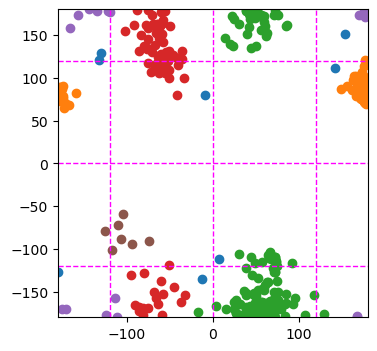

In [9]:
from sklearn.cluster import DBSCAN

data = ptm_data[ptm_data.residue=="SEP"][["chi2", "chi1"]]
fit_data = np.stack((np.cos(np.radians(data)), np.sin(np.radians(data))), axis=1)
clustering = DBSCAN(eps=0.4, min_samples=3).fit(fit_data.transpose(0, -1, 1).reshape(-1, 4))

plt.figure(figsize=(4, 4))
for l in np.unique(clustering.labels_):
    plt.scatter(data[clustering.labels_ == l].chi1, data[clustering.labels_ == l].chi2)

plt.xlim(-180, 180)
plt.ylim(-180, 180)

# Highlight grid lines at x = [-120, 0, 120] and y = [-120, 0, 120] with magenta
for val in [120, 0, -120]:
    plt.axvline(x=val, color='magenta', linestyle='--', linewidth=1)
    plt.axhline(y=val, color='magenta', linestyle='--', linewidth=1)


In [10]:
ptm = "SEP"
#calculate terminal rotamer
data = ptm_data[ptm_data.residue==ptm]

r3_stats = np.zeros((3, 3))
r3_class = data[free_rotamer[ptm]].apply(rotameric_class)
for l in range(3):
    ang_rad = data[r3_class==l][free_rotamer[ptm]].apply(np.radians)
    kappa, loc, _ = vonmises.fit(ang_rad, fscale=1)
    weights = vonmises(loc=loc, kappa=kappa).pdf(ang_rad)
    wm = weighted_circmean(ang_rad, weights)
    r3_stats[l, 0] = len(ang_rad)/len(data)
    r3_stats[l, 1] = np.degrees(wm)
    r3_stats[l, 2] = np.degrees(weighted_circstd(ang_rad, weights, wm))

In [11]:
results = []

for l in np.unique(clustering.labels_):
    angles = data[clustering.labels_ == l]
    if l == -1:
        # for outliers just append individual point    
        for _, pt in angles.iterrows():
            line = np.concatenate(([1/len(data)], pt[[f"chi{n+1}" for n in range(nchis[ptm])]].values, np.zeros(nchis[ptm])))
            results.append(line)
    else:
        line = np.zeros(1+nchis[ptm]*2)
        for n in range(3):
            ang_rad = angles[f"chi{n+1}"].apply(np.radians)
            kappa, loc, _ = vonmises.fit(ang_rad, fscale=1)
            weights = vonmises(loc=loc, kappa=kappa).pdf(ang_rad)
            wm = weighted_circmean(ang_rad, weights)
            line[1+n] = np.degrees(wm)
            line[1+n+nchis[ptm]] = np.degrees(weighted_circstd(ang_rad, weights, wm))
        
        for r3 in r3_stats:
            #factor in free rotamer
            line[0] = len(angles) / len(data) * r3[0]
            line[-1-nchis[ptm]] = r3[1]
            line[-1] = r3[2]  
            results.append(line.copy())

In [12]:
table = format_bb_indp_table(results, ptm)
#print(table)
with open("sep_bi.lib", "w") as f:
    f.write(table)

backbone dependent rotamer library

In [13]:
header = "#AA   PHI   PSI    Prob   "
line_formatter = "{: <3}  {:4d}  {:4d}  {:8.4f}" #"{:8.1f}""{:8.2f}"

def get_closest_angle(input_angle, degsep=10):
    """
    Find closest angle in [-180, +170] with n degree separations
    """
    if input_angle > 180 - degsep/2.:
        # the closest would be 180, namely -180
        return -180
    return round(input_angle/degsep)*degsep 

def format_bbdp_table(lines, residue):
    n_ang = (len(lines[0]) - 3) // 2
    formatter = line_formatter + "{:8.1f}" * n_ang + "{:8.2f}" * n_ang
    table = header + " ".join([f"chi{i+1}Val" for i in range(n_ang)]) + " " + " ".join([f"chi{i+1}Sig" for i in range(n_ang)]) + "\n"
    #table = ""
    for l in lines:
        table += formatter.format(residue, int(l[0]), int(l[1]), *l[2:]) + "\n"
    return table

In [14]:
def calc_bb_dependent(ptm, data, bb_sep=30, last_free_rot=False):
    results = []
    nchi = nchis[ptm]

    #scbins = product(range(3), repeat=nchi)
    chi_classes = []
    for n in range(nchis[ptm]):
        chi_classes.append(data[f"chi{n+1}"].apply(lambda x: rotameric_class(x, rot_bin_lib.get((ptm, n), 3))).values)
    effect_chi_classes = np.array(chi_classes)
    if last_free_rot:
        nchi -= 1
        effect_chi_classes = effect_chi_classes[:-1]

    #bbins = product(range(360//bb_sep), repeat=2)
    bb_classes = []
    for ang in ["phi", "psi"]:
        bb_classes.append(data[ang].apply(lambda x: get_closest_angle(x, bb_sep)))
    bb_classes = np.array(bb_classes)

    for b in np.unique(bb_classes.T, axis=0):
        bb_mask = np.ones(len(data), dtype=bool)
        for i, l in enumerate(b):
            bb_mask &= bb_classes[i] == l
        if np.sum(bb_mask) == 0:
            continue
        if np.sum(bb_mask) == 1:
            line = np.concatenate(([int(b[0]), int(b[1]), 1/np.sum(bb_mask)], 
                                    data[bb_mask][[f"chi{n+1}" for n in range(nchis[ptm])]].values[0], np.zeros(nchis[ptm])))
            results.append(line)
            continue

        for c in np.unique(effect_chi_classes.T, axis=0):  
            mask = bb_mask.copy()
            for i, l in enumerate(c):
                mask &= effect_chi_classes[i] == l
            if np.sum(mask) == 0:
                continue

            angles = data[mask]
            if np.sum(mask) == 1:
                line = np.concatenate(([int(b[0]), int(b[1]), 1/np.sum(bb_mask)], 
                                       angles[[f"chi{n+1}" for n in range(nchis[ptm])]].values[0], np.zeros(nchis[ptm])))
            else:
                line = np.zeros(2*nchis[ptm] + 3)
                prob = np.sum(mask) / np.sum(bb_mask)
                line[0] = int(b[0])
                line[1] = int(b[1])
                for n in range(nchi):
                    ang_rad = angles[f"chi{n+1}"].apply(np.radians)
                    kappa, loc, _ = vonmises.fit(ang_rad, fscale=1)
                    weights = vonmises(loc=loc, kappa=kappa).pdf(ang_rad)
                    wm = weighted_circmean(ang_rad, weights)
                    line[3+n] = np.degrees(wm)
                    line[3+n+nchis[ptm]] = np.degrees(weighted_circstd(ang_rad, weights, wm))
                if last_free_rot:
                    for j in range(3):
                        sub_mask = bb_mask & (chi_classes[-1]==j)
                        line[2] = prob * np.sum(sub_mask) / np.sum(bb_mask)
                        ang_rad = data[sub_mask][f"chi{nchis[ptm]}"].apply(np.radians)
        
                        if len(ang_rad) == 0:
                            continue
                        elif len(ang_rad) == 1:
                            line[-1-nchis[ptm]] = np.degrees(ang_rad.values)
                            line[-1] = 0.
                            results.append(line.copy())
                            continue
                        kappa, loc, _ = vonmises.fit(ang_rad, fscale=1)
                        weights = vonmises(loc=loc, kappa=kappa).pdf(ang_rad)
                        wm = weighted_circmean(ang_rad, weights)
                        line[-1-nchis[ptm]] = np.degrees(wm)
                        line[-1] = np.degrees(weighted_circstd(ang_rad, weights, wm))
                        if line[-1] > 30:
                            print(np.degrees(ang_rad))
                        results.append(line.copy())
                    continue
                line[2] = prob
            results.append(line)
        
    return results


In [16]:
data = ptm_data[ptm_data.residue=="ALY"]
results = calc_bb_dependent("ALY", data, bb_sep=30, last_free_rot=False)
table = format_bbdp_table(results, "ALY")
with open("aly_bd.lib", "w") as f:
    f.write(table)